In [1]:
from lsst.resources import ResourcePath
from astropy.io import fits
import os
import numpy
from astropy.table import Table
from dateutil.parser import parse
import re
import json

#MC_C_20240918_000019_R40_SG1_guider.fits
prefix = 'MC_C_'
p = re.compile( rf'{prefix}(\d*)_(\d*)_(R.._S..)_guider.fits' )


In [2]:
def examineone(fname):
    date, seqnum, sensor = p.match(fname).groups()
    path = f's3://embargo@rubin-summit/LSSTCam/{date}/{prefix}{date}_{seqnum}/{fname}'
    rp=ResourcePath(path)
    with rp.open(mode="rb") as f:
        hdu_list = fits.open(f)
    stdnoise = numpy.mean(list(map( lambda x: numpy.std(x.data), hdu_list[1:]))[1:]) 
    stdstdnoise = numpy.std(list(map( lambda x: numpy.std(x.data), hdu_list[1:]))[1:]) 
    hz = 1/numpy.mean(numpy.diff(list(map( lambda x: parse(x.header['STMPTIME']), hdu_list[1:]) )[1:])).total_seconds()
    
    return {
        's3path': rp,
        'basename': rp.abspath().basename(),
        'noise': stdnoise,
        'std(noise)': stdstdnoise,        
        'Hz': hz
    }
    

In [3]:
table=Table(
    list(map( lambda x: examineone(x), [
        'MC_C_20240918_000019_R40_SG1_guider.fits',
        'MC_C_20240916_000327_R00_SG0_guider.fits'
    ])
       )
)
table['basename','noise','std(noise)','Hz']

basename,noise,std(noise),Hz
str40,float64,float64,float64
MC_C_20240918_000019_R40_SG1_guider.fits,9.212806203560172,0.12484796887863193,9.163131225202276
MC_C_20240916_000327_R00_SG0_guider.fits,4.6481357175004225,0.01161241270003768,2.2182490916269972


In [4]:
rp = ResourcePath(table[0]['s3path'].geturl().replace('.fits','.json'))
with rp.open(mode="r") as f:
    print(json.load(f))

{'__CONTENT__': 'metadata', 'SIMPLE': True, 'BITPIX': 8, 'NAXIS': 0, 'EXTEND': True, 'BINX': 1, 'BINY': 1, 'CCDGAIN': 1.0, 'CCDNOISE': 10.0, 'DETSIZE': '[1:4072,1:4000]', 'DATE': '2024-09-18T17:15:03.041', 'MJD': 60571.71878519654, 'IMGTYPE': 'UNKNOWN', 'OBSID': 'MC_C_20240918_000019', 'BUNIT': 'adu', 'TIMESYS': 'TAI', 'INSTRUME': 'lsstCam', 'TELESCOP': 'Simonyi Survey Telescope', 'OBS-LONG': None, 'OBS-LAT': None, 'OBS-ELEV': None, 'OBSGEO-X': None, 'OBSGEO-Y': None, 'OBSGEO-Z': None, 'RA': None, 'DEC': None, 'RASTART': None, 'DECSTART': None, 'RAEND': None, 'DECEND': None, 'ROTPA': None, 'ROTCOORD': None, 'HASTART': None, 'ELSTART': None, 'AZSTART': None, 'AMSTART': None, 'HAEND': None, 'ELEND': None, 'AZEND': None, 'AMEND': None, 'TRACKSYS': None, 'RADESYS': None, 'FOCUSZ': None, 'OBJECT': None, 'VIGNETTE': None, 'VIGN_MIN': None, 'CAMCODE': 'MC', 'CONTRLLR': 'C', 'DAYOBS': '20240918', 'SEQNUM': 19, 'PROGRAM': None, 'REASON': None, 'TSTAND': 'BOT', 'CCD_MANU': 'ITL', 'CCD_TYPE': '38

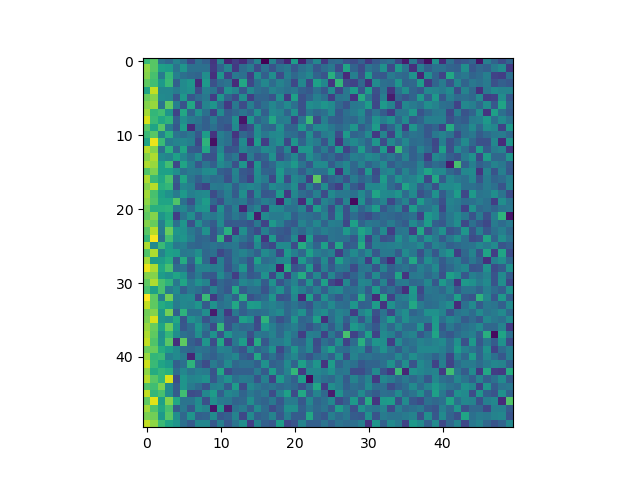

In [8]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from astropy.io import fits
%matplotlib widget


# Open the FITS file
with table[0]['s3path'].open(mode='rb') as f:
    fh = fits.open(f)

# Create the figure and axis
fig, ax = plt.subplots()

# Prepare the frames (each should be a list of images/artists)
frames = [[plt.imshow(img.data, animated=True)] for img in fh[1:]]

# Create the animation
ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)

# Show the animation
plt.show()